In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from scipy.interpolate import griddata
import math

In [245]:
# This function will be used to convert km from radar to lat/lon of each pixel
# Credit to ChatGPT 3.5 for the function code

def calculate_new_coordinates(origin, distance_ns, distance_ew):
    """
    Calculate new latitude and longitude based on distances in the north-south and east-west directions.

    Parameters:
    - origin: Tuple of (latitude, longitude) for the starting point.
    - distance_ns: Distance in kilometers in the north-south direction.
    - distance_ew: Distance in kilometers in the east-west direction.

    Returns:
    - Tuple of (latitude, longitude) for the new point.
    """
    # Radius of the Earth in kilometers
    earth_radius = 6371.0

    # Unpack the origin coordinates
    lat1, lon1 = origin

    # Calculate new latitude
    lat2 = lat1 + (distance_ns / earth_radius) * (180.0 / math.pi)

    # Calculate new longitude
    lon2 = lon1 + (distance_ew / earth_radius) * (180.0 / math.pi) / math.cos(lat1 * math.pi / 180.0)

    return lat2, lon2

In [246]:
####################### FORMATTING KLIX RAIN RATE DATA ####################################

#Using CSV from rainfall rate equations in Lab 3...
XX = pd.read_csv('C:/Users/micha/Documents/XX.csv')
YY = pd.read_csv('C:/Users/micha/Documents/YY.csv')
rr = pd.read_csv('C:/Users/micha/Documents/RosenfeldRates.csv')

# This takes the original latitude and longitude of KLIX radar to switch from km to lat/lon 
origin_point = (30.336667, -89.825417)  # Latitude and longitude of KLIX radar at time of file
distance_ns = YY  # Distance from radar in N-S direction, based on csv file
distance_ew = XX   # Distance from radar in E-W direction, based on csv file

# This gets the new latitude and longitude numpy arrays, instead of km pandas arrays
lat2, lon2 = calculate_new_coordinates(origin_point, distance_ns, distance_ew)
latnp = np.array(lat2)
lonnp = np.array(lon2)
rrnp = np.array(rr)

In [257]:
################## FORMATTING IMERG FINAL QPE (HALF-HOURLY) #########################

# This grabs the Final IMERG Half-Hourly Precip Data I have saved
fn = 'C:/Users/micha/Downloads/3B-HHR.MS.MRG.3IMERG.20210829-S160000-E162959.0960.V07A.HDF5'
f = h5py.File(fn, 'r')

# This shows the groups/variables in the HDF5 file... I will be using Grid/precipitation
groups = [ x for x in f.keys() ]
# print(groups)
gridMembers = [ x for x in f['Grid'] ]
# print(gridMembers)

# Get the precipitation, latitude, and longitude variables
precip = f['Grid/precipitation'][0][:][:]
precip = np.transpose(precip) # Honestly not sure why, but I had to transpose the precip
theLats = f['Grid/lat'][:]
theLons = f['Grid/lon'][:]
x, y = np.float32(np.meshgrid(theLons, theLats))
precip[precip < 0] = np.nan # This is just incase there are any negative rain rate values
a = np.nanmax(precip) # This is how I find out what color-bar limits to use, ignoring NaNs
print('Max Rainfall Rate throughout the World (according to IMERG): '+str(a)+' mm/hr')
lon_mesh = x[1176:1231,870:933] # The ranges are based on min/max longitudes and latitudes
lat_mesh = y[1176:1231,870:933]
precip_mesh = precip[1176:1231,870:933]

Max Rainfall Rate throughout the World (according to IMERG): 45.82 mm/hr


In [258]:
############### MAKING A COMMON GRID TO COMPARE IMERG AND KLIX ########################

# These are the max/min latitudes and longitudes of KLIX data
start_latitude = 33.03
end_latitude = 27.64
start_longitude = -92.95
end_longitude = -86.70

# Calculate the number of points needed for a step size of 0.1 degree
step_size = 0.1 # I determined this step size based on resolution of IMERG Final Data
num_points_lat = int(np.ceil((start_latitude - end_latitude) / step_size)) + 1
num_points_lon = int(np.ceil((abs((start_longitude) - (end_longitude))) / step_size)) + 1

# This creates a numpy array of latitude values
new_latitude_values = np.linspace(start_latitude, end_latitude, num_points_lat)
new_longitude_values = np.linspace(start_longitude, end_longitude, num_points_lon)

# Create a common grid
common_grid_lon, common_grid_lat = np.meshgrid(new_longitude_values,new_latitude_values)

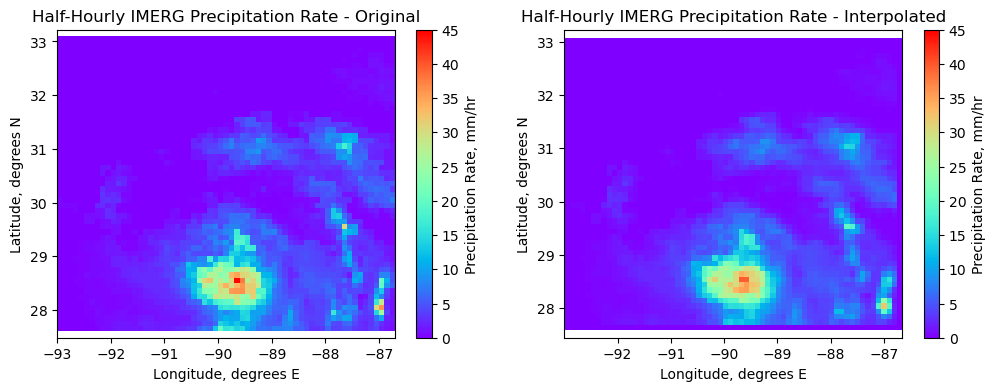

In [259]:
###################### INTERPOLATE AND PLOT IMERG DATA ####################################

# Use 'griddata' to interpolate the values of the IMERG Rainfall Rates on the common grid
common_grid_IMERG = griddata((lon_mesh.flatten(), lat_mesh.flatten()), precip_mesh.flatten(), (common_grid_lon.flatten(), common_grid_lat.flatten()), method='linear')

# Reshape the interpolated array back to the 2D grid
common_grid_IMERG = common_grid_IMERG.reshape(common_grid_lon.shape)
# Now, common_grid_z1 and common_grid_z2 contain the interpolated values on the common grid

#Make the common_grid_KLIX NaN values (where the radar doesn't hit) = 0
common_grid_IMERG = np.where(np.isnan(common_grid_IMERG),0,common_grid_IMERG)

# Make one single figure for both original and interpolated
plt.figure(figsize=(12, 4))

# Plot the original IMERG data
plt.subplot(1, 2, 1)
plt.pcolormesh(lon_mesh, lat_mesh, precip_mesh, shading='auto', cmap=plt.cm.rainbow, vmin=0, vmax=45)
plt.colorbar(label='Precipitation Rate, mm/hr')
plt.title('Half-Hourly IMERG Precipitation Rate - Original')
plt.axis('equal')
plt.xlabel('Longitude, degrees E')
plt.ylabel('Latitude, degrees N')

# Plot the interpolated IMERG data on common grid
plt.subplot(1, 2, 2)
plt.pcolormesh(common_grid_lon, common_grid_lat, common_grid_IMERG, shading='auto', cmap=plt.cm.rainbow, vmin=0, vmax=45)
plt.colorbar(label='Precipitation Rate, mm/hr')
plt.title('Half-Hourly IMERG Precipitation Rate - Interpolated')
plt.axis('equal')
plt.xlabel('Longitude, degrees E')
plt.ylabel('Latitude, degrees N')
plt.show()

C:\Users\micha\AppData\Local\Temp\ipykernel_11652\2795869000.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lonnp, latnp, rrnp, shading='auto', cmap=plt.cm.rainbow, vmin=0, vmax=100)


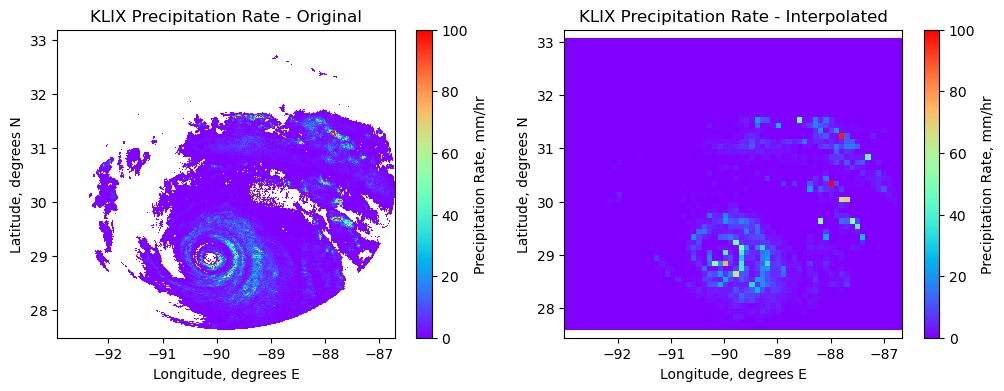

In [260]:
###################### INTERPOLATE AND PLOT KLIX DATA ####################################

# Use griddata to interpolate the values of the KLIX Radar Rainfall Rates on the common grid
common_grid_KLIX = griddata((lonnp.flatten(), latnp.flatten()),rrnp.flatten(), (common_grid_lon.flatten(), common_grid_lat.flatten()), method='linear')

# Reshape the interpolated array back to the 2D grid
common_grid_KLIX = common_grid_KLIX.reshape(common_grid_lon.shape)
# Now, common_grid_z1 and common_grid_z2 contain the interpolated values on the common grid

#Make the common_grid_KLIX NaN values (where the radar doesn't hit) = 0
common_grid_KLIX = np.where(np.isnan(common_grid_KLIX),0,common_grid_KLIX)

# Make one single figure for both original and interpolated
plt.figure(figsize=(12, 4))

# Plot the original KLIX data
plt.subplot(1, 2, 1)
plt.pcolormesh(lonnp, latnp, rrnp, shading='auto', cmap=plt.cm.rainbow, vmin=0, vmax=100)
plt.colorbar(label='Precipitation Rate, mm/hr')
plt.title('KLIX Precipitation Rate - Original')
plt.axis('equal')
plt.xlabel('Longitude, degrees E')
plt.ylabel('Latitude, degrees N')

# Plot the interpolated KLIX data on common grid
plt.subplot(1, 2, 2)
plt.pcolormesh(common_grid_lon, common_grid_lat, common_grid_KLIX, shading='auto', cmap=plt.cm.rainbow, vmin=0, vmax=100)
plt.colorbar(label='Precipitation Rate, mm/hr')
plt.title('KLIX Precipitation Rate - Interpolated')
plt.axis('equal')
plt.xlabel('Longitude, degrees E')
plt.ylabel('Latitude, degrees N')
plt.show()

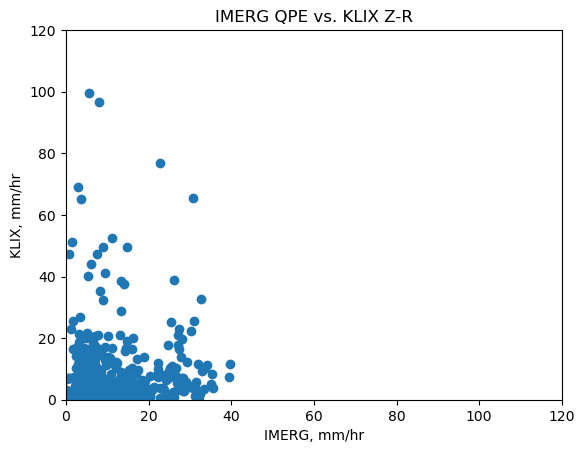

Correlation Coefficient (CC): 0.396663881784491
P-value: 5.625857735628003e-133
Mean Absolute Error (MAE): 2.256472011758172
Mean Standard Error (MSE): 32.05938172193612
Root Mean Square Error (RMSE): 5.662100469078248


In [261]:
########### CALCULATE AND PLOT STATISTICS OF IMERG VS KLIX COMPARISON #####################

# Create a scatterplot with IMERG on x-axis and KLIX on y-axis
plt.scatter(common_grid_IMERG, common_grid_KLIX)
plt.axis([0,120,0,120]) # I want to keep the axes the same length
plt.xlabel('IMERG, mm/hr')
plt.ylabel('KLIX, mm/hr')
plt.title('IMERG QPE vs. KLIX Z-R')
plt.show()

# Calculate the Pearson correlation coefficient and p-value for each point
correlation_coefficient, p_value = pearsonr(common_grid_IMERG.flatten(), common_grid_KLIX.flatten())
print(f"Correlation Coefficient (CC): {correlation_coefficient}")
print(f"P-value: {p_value}")

#Calculate the Mean Absolute Error (MAE)
MAE = mae(common_grid_IMERG, common_grid_KLIX)
print('Mean Absolute Error (MAE): '+str(MAE))

#Calculate Mean Square Error (MSE)
MSE = mse(common_grid_IMERG, common_grid_KLIX)
print('Mean Standard Error (MSE): '+str(MSE))

#Calculate Root Mean Square Error (RMSE)
RMSE = math.sqrt(MSE)
print('Root Mean Square Error (RMSE): '+str(RMSE))